In [1]:
import sys
sys.path.append('../Scripts')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
import numpy as np

from capstone_functions import *

# Results : 
based on comparing scores on 0.3 holdout set.
Algorithms:
K-medoids performs better on train and test set in case with low levels of outlier filtering.
Outlier Filtering
filter between 0.1 percent and 1 percent (.6 to .7) are the best 
CLusters:
saturday 2 is bad
off_peak_split and holiday simple / holiday_6 are all good
### 

In [2]:
def prepare_data_for_scoring(
                input_path='../Inputs/',
                crash_source_csv='Train',
                outlier_filter=0,
                holdout_strategy='random', 
                holdout_test_size=0.3,
                tw_cluster_strategy='saturday_2', 
                verbose=0,
                placement_method='k_means'
                ):
    crash_df = create_crash_df(train_file = input_path+crash_source_csv+'.csv')
    # create individual date and time features from date column
    crash_df = create_temporal_features(crash_df)
    # split data into train and test sets
    train_df, test_df = split_accident_df(data=crash_df, strategy=holdout_strategy,
                                          test_size=holdout_test_size)
    # remove outliers from test set based on lat and lon
    train_df = outlier_removal(train_df, filter=outlier_filter)
    # apply time window cluster labels to df based on strategy specified
    train_df = create_cluster_feature(train_df, strategy=tw_cluster_strategy, verbose=verbose)
    # Run clustering model to get placement set centroids for each TW cluster
    test_df_with_clusters = create_cluster_feature(test_df, strategy=tw_cluster_strategy, verbose=0)
    centroids_dict = create_cluster_centroids(train_df, test_df=test_df_with_clusters, verbose=verbose, method=placement_method)
    train_placements_df = centroid_to_submission(centroids_dict, date_start='2018-01-01', date_end='2019-12-31',
                                                 tw_cluster_strategy=tw_cluster_strategy,
                                                )
    test_score = score(train_placements_df, test_df, test_start_date='2018-01-01',
                       test_end_date='2019-12-31')
    #train_score = score(train_placements_df,train_df, test_start_date='2018-01-01',
    #                   test_end_date='2019-12-31')
    return (test_score/ max(test_df.shape[0],1)) #, (train_score/train_df.shape[0])

In [3]:
from tqdm import tqdm, trange
import numpy as np

In [4]:
def get_scores():
    score_list = []
    for model in tqdm(['k_medoids','k_means','agglomerative']):
        for cluster_strat in tqdm((['holiday_simple', 'off_peak_split'])):
            for out_filter in trange(20, 140, 20):
                # test_score, train_score = prepare_data_for_scoring(
                test_score = prepare_data_for_scoring(
                                                                input_path='../Inputs/',
                                                                crash_source_csv='Train',
                                                                outlier_filter=out_filter/10000,
                                                                holdout_strategy='random', 
                                                                holdout_test_size=0.3,
                                                                tw_cluster_strategy=cluster_strat, 
                                                                verbose=0,
                                                                placement_method=model

                )
                score_list.append([model, cluster_strat, out_filter/100, test_score]) #, train_score])
    return score_list

In [5]:
def gd_get_scores():
    score_list = []
    model ='gradient_descent'
    for cluster_strat in ((['holiday_simple', 'off_peak_split', 'holiday_6'])):
        for out_filter in range(20, 90, 10):
            # test_score, train_score = prepare_data_for_scoring(
            test_score = prepare_data_for_scoring(
                                                    input_path='/content/drive/MyDrive/nairobi_capstone/',
                                                    crash_source_csv='Train',
                                                    outlier_filter=out_filter/10000,
                                                    holdout_strategy='random', 
                                                    holdout_test_size=0.3,
                                                    tw_cluster_strategy=cluster_strat, 
                                                    verbose=0,
                                                    placement_method=model)

                    
            score_list.append([model, cluster_strat, out_filter/100, test_score]) #, train_score])
    return score_list

In [6]:
score_list =  get_scores()
k_compare = pd.DataFrame(score_list, columns=['model', 'cluster_strat', 'filter', 'test_score']) #, 'train_score'])

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:04<00:21,  4.34s/it]

 33%|███▎      | 2/6 [00:08<00:16,  4.21s/it]

 50%|█████     | 3/6 [00:12<00:12,  4.12s/it]

 67%|██████▋   | 4/6 [00:15<00:07,  3.91s/it]

 83%|████████▎ | 5/6 [00:18<00:03,  3.73s/it]

100%|██████████| 6/6 [00:22<00:00,  3.70s/it]

 50%|█████     | 1/2 [00:22<00:22, 22.21s/it]

  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:03<00:17,  3.42s/it]

 33%|███▎      | 2/6 [00:06<00:13,  3.38s/it]

 50%|█████     | 3/6 [00:09<00:10,  3.34s/it]

 67%|██████▋   | 4/6 [00:13<00:06,  3.33s/it]

 83%|████████▎ | 5/6 [00:16<00:03,  3.32s/it]

100%|██████████| 6/6 [00:19<00:00,  3.31s/it]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:03<00:19,  3.89s/it]

 33%|███▎      | 2/6 [00:07<00:15,  3.85s/it]

 50%|█████     | 3/6 [00:11<00:11,  3.90s/it]

 67%|██████▋   | 4/6 [00:15<00:07,  3.97s/it]

 83%|█

holiday_simple
off_peak_split


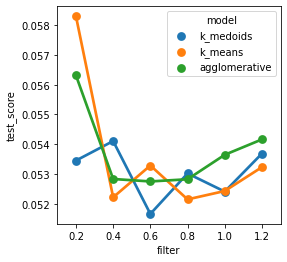

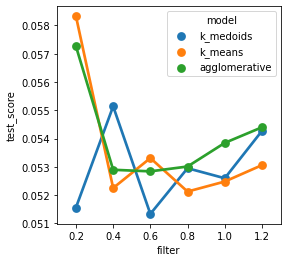

In [7]:
for i, strat in enumerate(k_compare['cluster_strat'].unique()):
    print(strat)
    df = k_compare.query('cluster_strat == @strat')
    fig, ax = plt.subplots(1, 1, sharex=True, figsize=(4, 4))
#    chart = sns.pointplot(ax=ax, data=df, x="filter", y='train_score', hue='model');
    chart = sns.pointplot(ax=ax, data=df, x="filter", y='test_score', hue='model');


In [13]:
#k_compare = pd.DataFrame(score_list, columns=['model', 'cluster_strat', 'filter', 'test_score']) #, 'train_score'])

In [27]:
k_compare.to_csv('../Outputs/k_compare_6.csv')

holiday_simple
off_peak_split
holiday_6


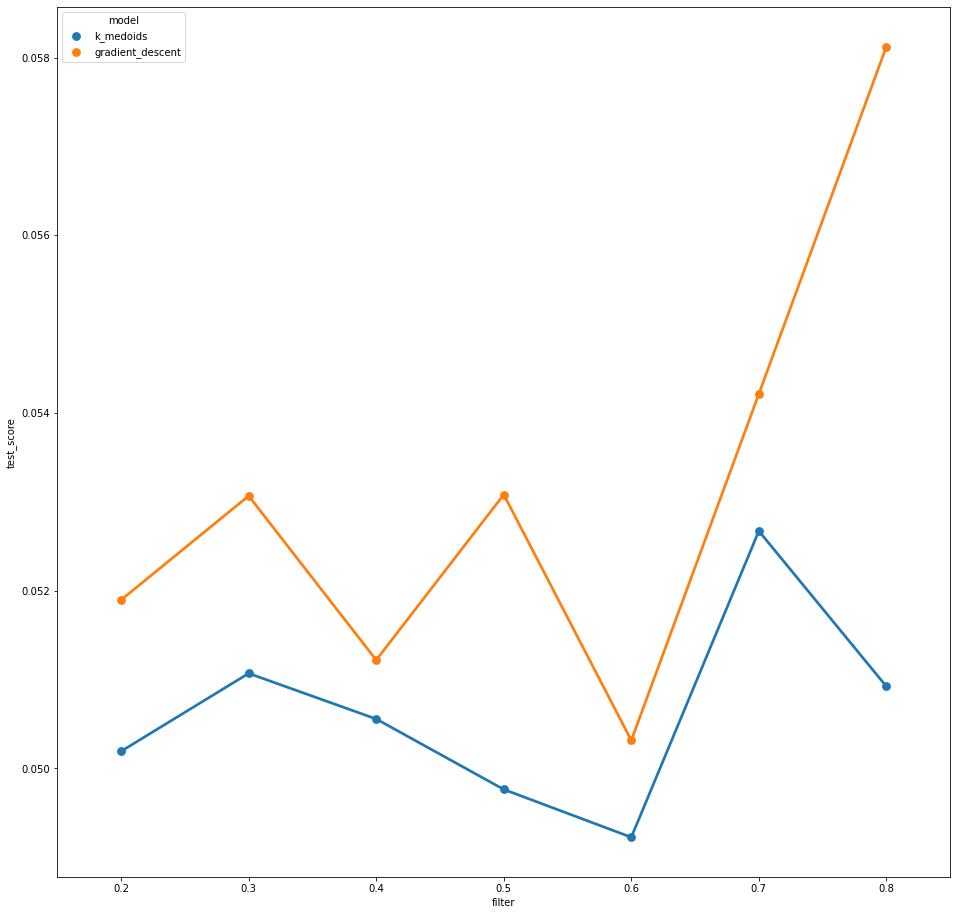

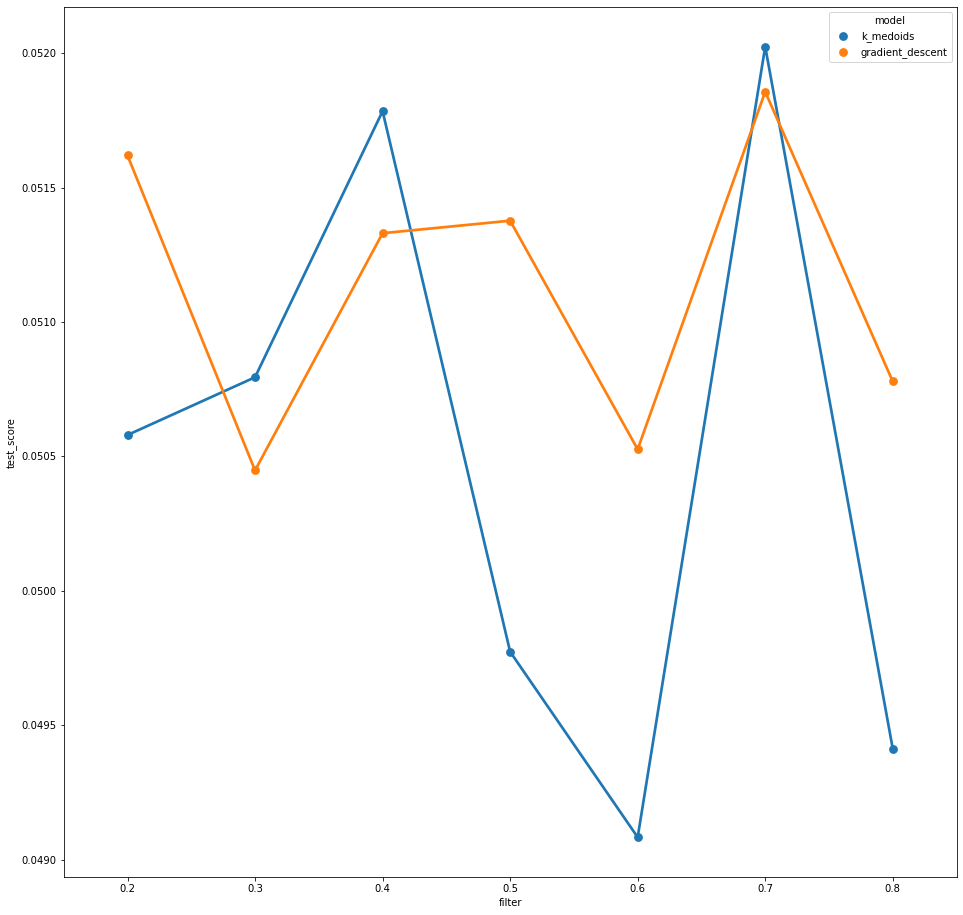

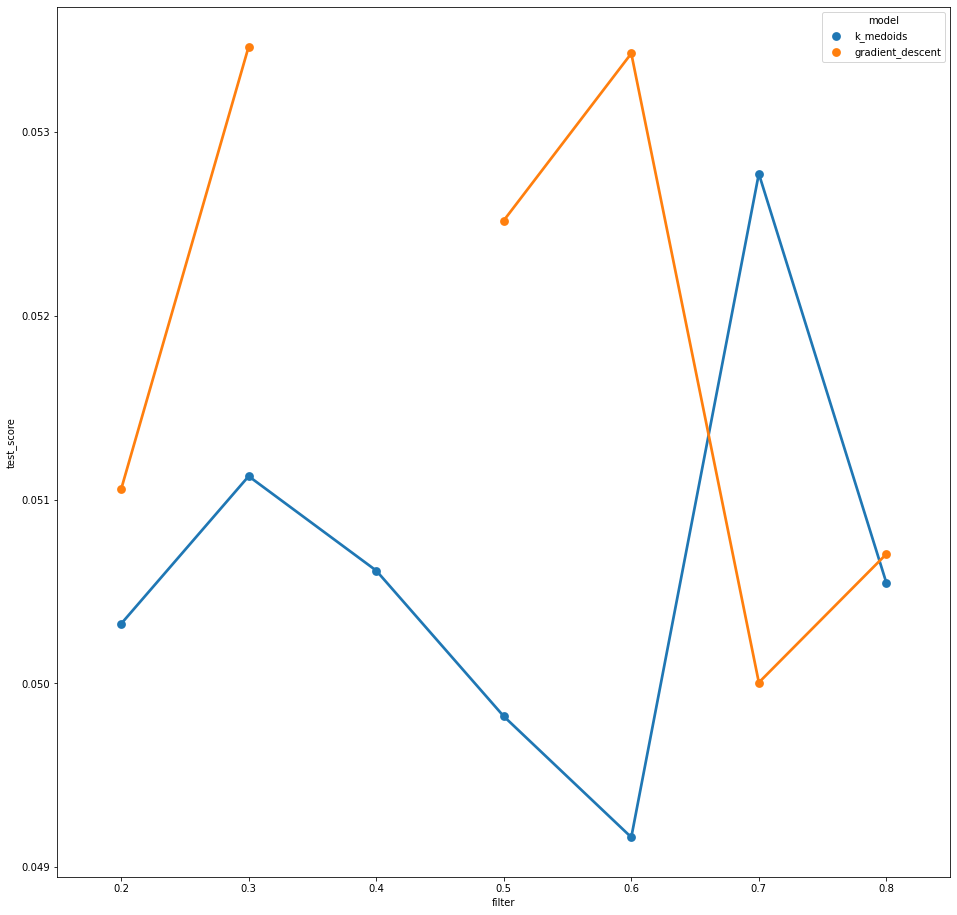

In [29]:
for i, strat in enumerate(k_compare['cluster_strat'].unique()):
    print(strat)
    df = k_compare.query('cluster_strat == @strat')
    fig, ax = plt.subplots(1, 1, sharex=True, figsize=(16, 16))
#    chart = sns.pointplot(ax=ax, data=df, x="filter", y='train_score', hue='model');
    chart = sns.pointplot(ax=ax, data=df, x="filter", y='test_score', hue='model');


k_medoids
gradient_descent


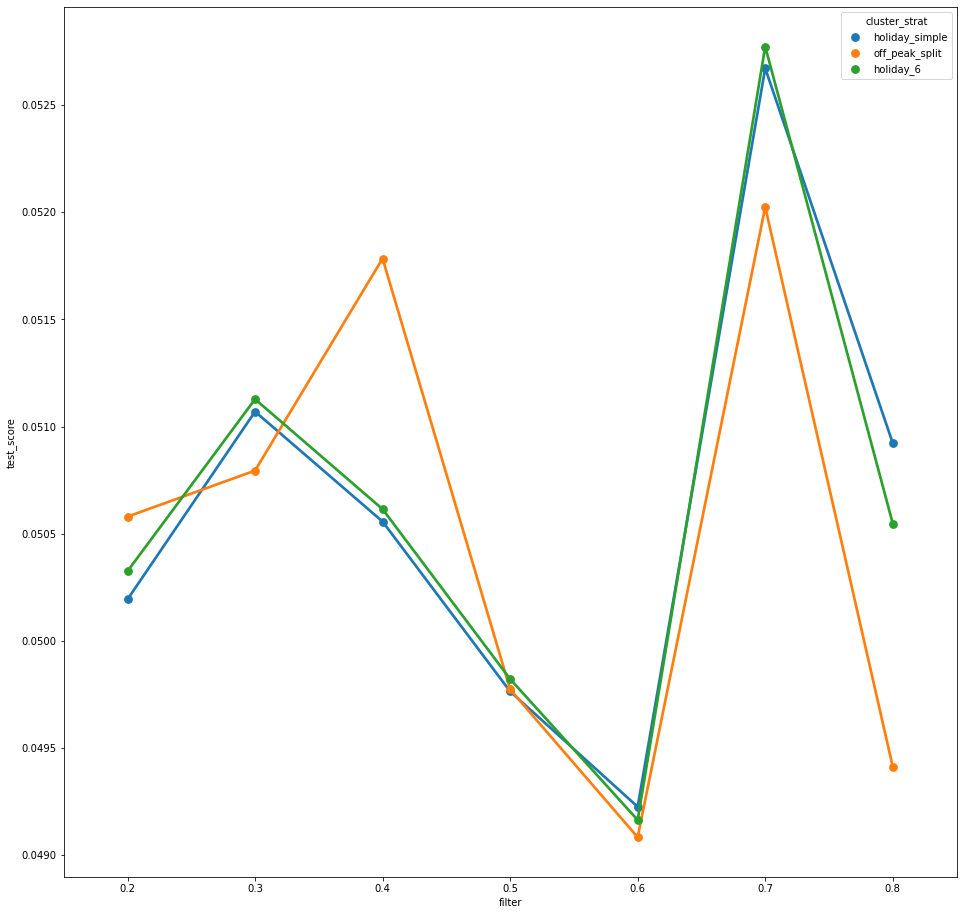

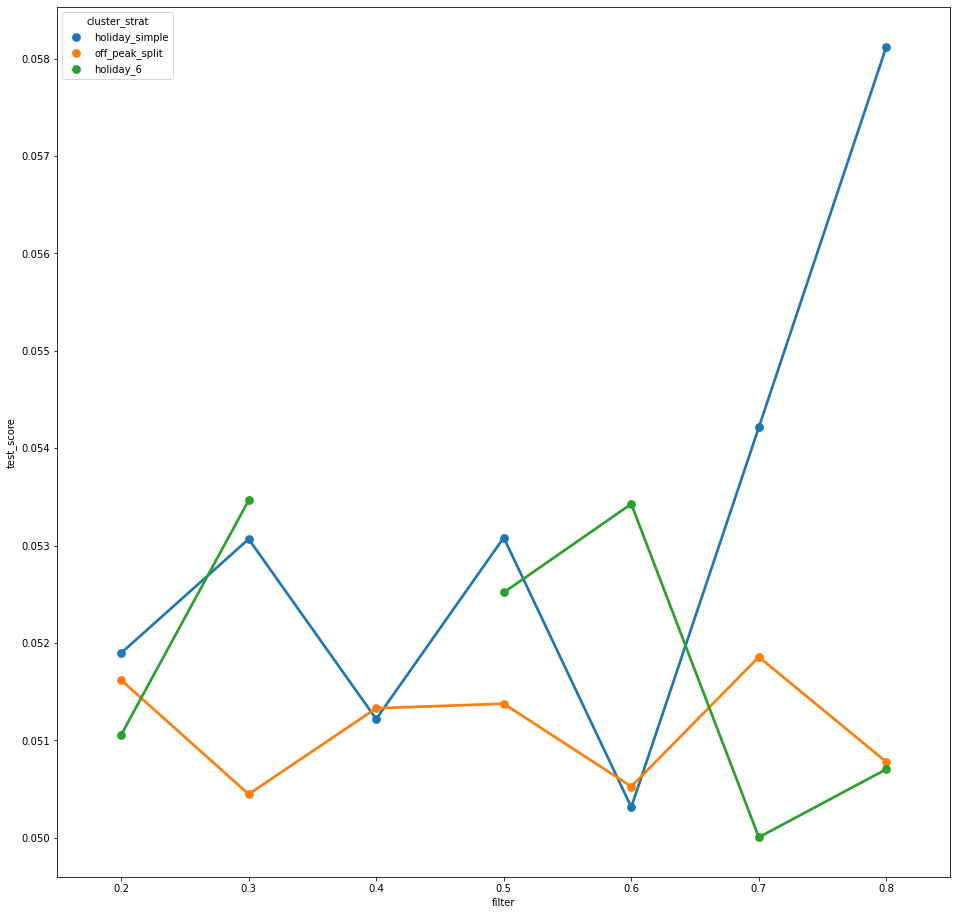

In [31]:
for i, model in enumerate(k_compare['model'].unique()):
    print(model)
    df = k_compare.query('model == @model')
    fig, ax = plt.subplots(1, 1, sharex=True, figsize=(16, 16))
#    chart = sns.pointplot(ax=ax, data=df, x="filter", y='train_score', hue='model');
    chart = sns.pointplot(ax=ax, data=df, x="filter", y='test_score', hue='cluster_strat');


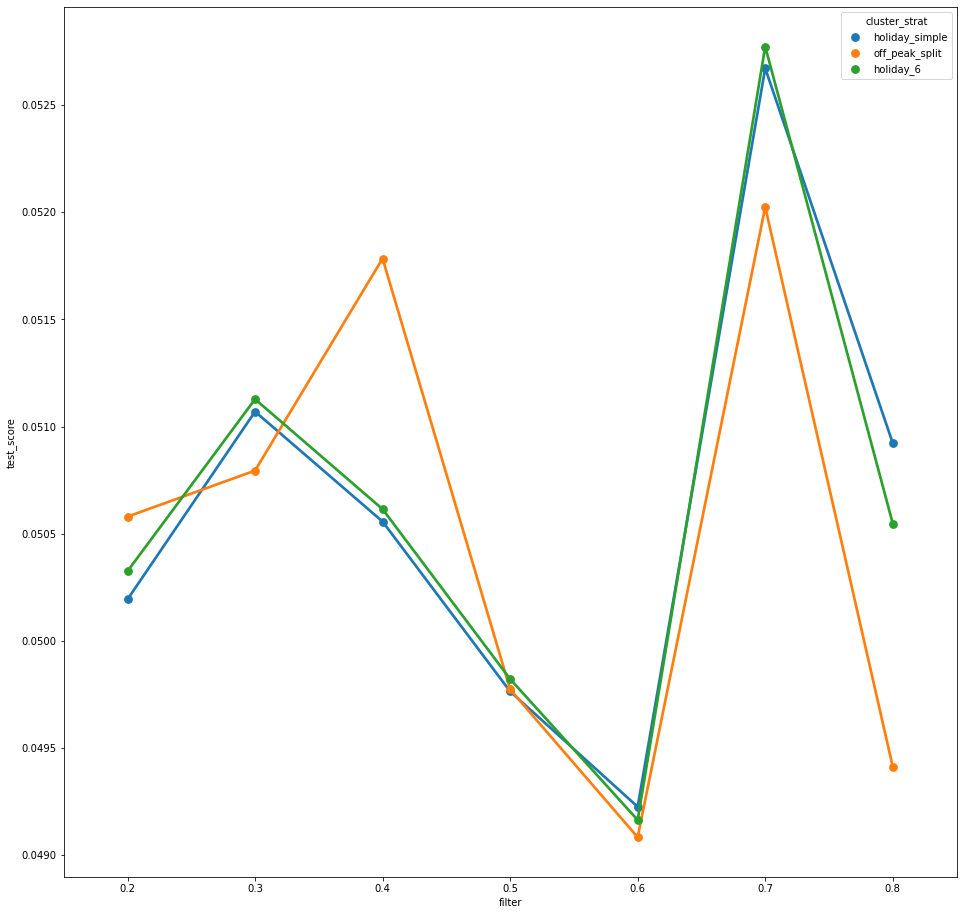

In [20]:
'''
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(16, 16))
#chart = sns.pointplot(ax=ax, data=k_compare, x="filter", y='train_score', hue='cluster_strat');
chart = sns.pointplot(ax=ax, data=k_compare, x="filter", y='test_score', hue='cluster_strat');
'''

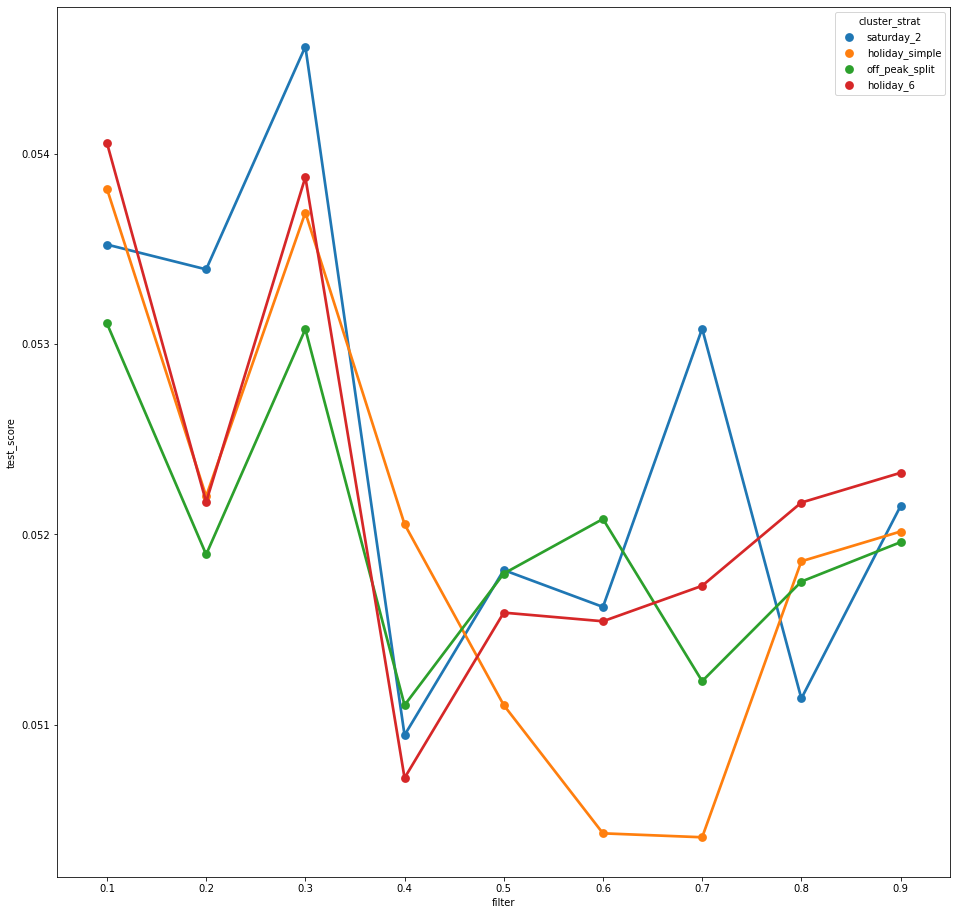

In [15]:
'''
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(16, 16))
#chart = sns.pointplot(ax=ax, data=k_compare, x="filter", y='train_score', hue='cluster_strat');
chart = sns.pointplot(ax=ax, data=k_compare, x="filter", y='test_score', hue='cluster_strat');
'''

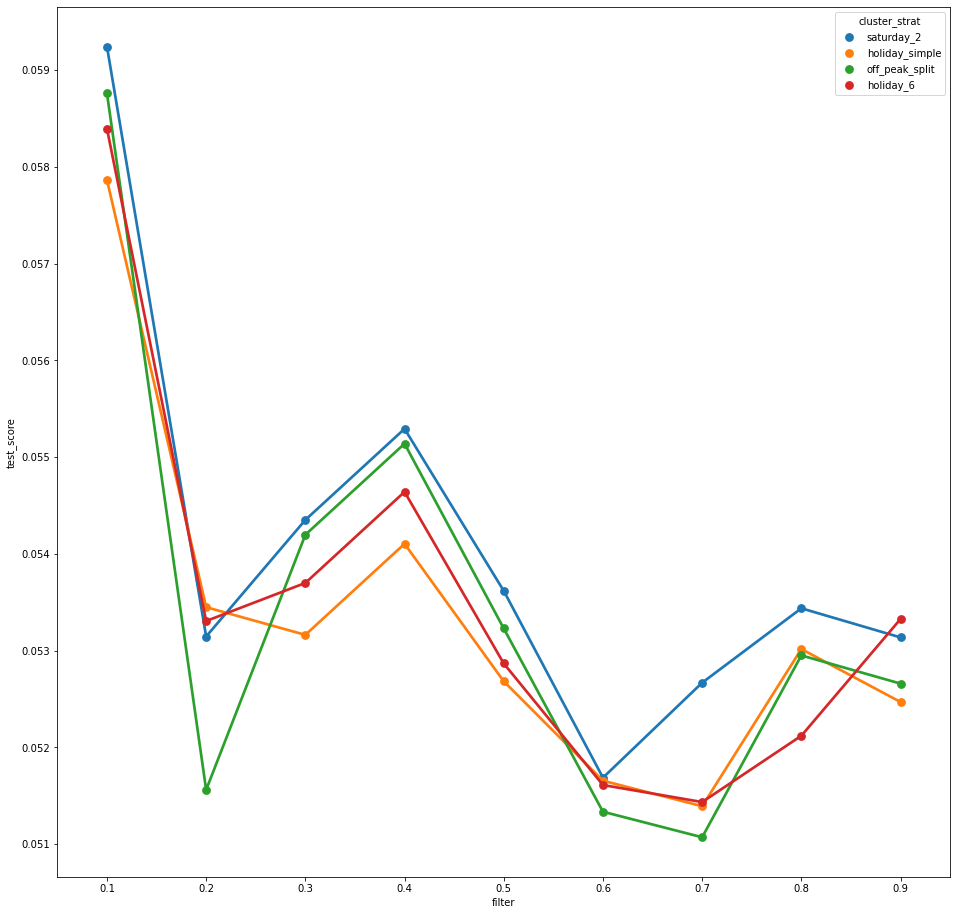

In [10]:
'''k_compare_1 = pd.read_csv('../Outputs/k_compare_1.csv')
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(16, 16))
#chart = sns.pointplot(ax=ax, data=k_compare, x="filter", y='train_score', hue='cluster_strat');
chart = sns.pointplot(ax=ax, data=k_compare_1, x="filter", y='test_score', hue='cluster_strat');
'''